# AlexNet Training

In this notebook we will train the implementation of the AlexNet class provided in the alexnet.py file. We will be using the CIFAR-10 dataset for this task. As, the input dimensions and the amount of data in CIFAR-10 differs from that of ImageNet, some modifications have been made in the training process.

In [1]:
import tensorflow as tf
import numpy as np

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [3]:
""" Get Data """

# File Path
CIFAR_DIR = 'Data/cifar-10-batches-py/'

# Load the Data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']
all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)
    
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [4]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [5]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


Loaded in this way, each of the batch files contains a dictionary with the following elements:

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image. labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data. The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

(-0.5, 31.5, 31.5, -0.5)

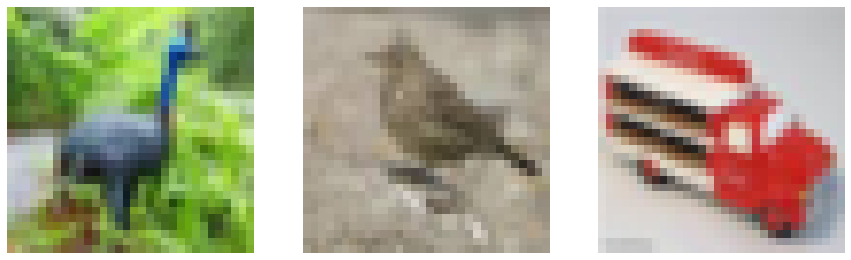

In [6]:
# Display the Data Images# Displ 
import matplotlib.pyplot as plt
%matplotlib inline

X = data_batch1[b"data"] 
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,3,1)
plt.imshow(X[6])
plt.axis('off')
fig.add_subplot(1,3,2)
plt.imshow(X[120])
plt.axis('off')
fig.add_subplot(1,3,3)
plt.imshow(X[360])
plt.axis('off')

## Helper Functions for Dealing With Data.

In [7]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [8]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

## Creating the AlexNet Model

In [9]:
from alexnet import AlexNet

In [10]:
#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape = [None, 10])
keep_prob = tf.placeholder(tf.float32)

# Create the AlexNet model
model = AlexNet(x = x, keep_prob = keep_prob, num_classes = 10)

#define activation of last layer as score
score = model.fc8

### Loss Function

In [15]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = score))

In [ ]:
Just use
from tensorflow.contrib import rnn
lstm_cell = rnn.BasicLSTMCell(rnn_size)
outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

instead of
from tensorflow.python.ops import rnn, rnn_cell
lstm_cell = rnn_cell.BasicLSTMCell(rnn_size,state_is_tuple=True)
outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)﻿

### Optimizer

In [16]:
# The optimiser used in this implementation is different
# to that used in the paper.
optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)
train = optimizer.minimize(cross_entropy)

In [17]:
# Initialize all global variables
init = tf.global_variables_initializer()

### Graph Session

In [18]:
# steps = 10,000 will create 20 epochs.
# There are a total of 50,000 images in the training set.
# (10,000 * 100) / 50,000 = 20
steps = 10001

ch = CifarHelper()
# pre-processes the data.
ch.set_up_images()

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        # get next batch of data.
        batch = ch.next_batch(100)
        # On training set.
        sess.run(train, feed_dict = {x : batch[0], y_true : batch[1], keep_prob : 0.5})
        
        # Print accuracy after every epoch.
        # 500 * 100 = 50,000 which is one complete batch of data.
        if i%500 == 0:
            
            print("EPOCH: {}".format(i / 500))
            print("ACCURACY ")
            
            matches = tf.equal(tf.argmax(score, 1), tf.argmax(y_true, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            
            # On valid/test set.
            print(sess.run(acc, feed_dict = {x : ch.test_images, y_true : ch.test_labels, keep_prob : 1.0}))
            print('\n')

Setting Up Training Images and Labels
Setting Up Test Images and Labels
EPOCH: 0.0
ACCURACY 
0.1


EPOCH: 1.0
ACCURACY 
0.219


EPOCH: 2.0
ACCURACY 
0.2801




KeyboardInterrupt: 